# Pickstock
## Importing Modules
The `gamspy` Python package is loaded in order to access GAMSPy syntax.

In [1]:
# Install dependencies
! pip install -q gamspy

In [2]:
from gamspy import Container, Sum, Sense, Card

## Loading the price data
The price data is provided from a CSV file located on the web. The Python package **pandas** is used to load the data. 

In [3]:
import pandas as pd

url = (
    "https://github.com/daveh19/pydataberlin2017/raw/master/notebooks/dowjones2016.csv"
)
price_data = pd.read_csv(url)

In [4]:
m = Container()
date = m.addSet("date", description="trading date")
symbol = m.addSet("symbol", description="stock symbol")
price = m.addParameter(
    "price",
    [date, symbol],
    domain_forwarding=True,
    records=price_data,
    description="price of stock on date",
)
d = m.addAlias("d", date)
s = m.addAlias("s", symbol)

In [5]:
price.records.head()

,date,symbol,value
0,2016-01-04,AAPL,105.349998
1,2016-01-04,AXP,67.589996
2,2016-01-04,BA,140.500000
3,2016-01-04,CAT,67.989998
4,2016-01-04,CSCO,26.410000


The mean price per stock is calculated in GAMS.

In [6]:
avgprice = m.addParameter("avgprice", symbol, description="average price of stock")
avgprice[s] = Sum(d, price[d, s]) / Card(d)

avgprice.records.head()

,symbol,value
0,AAPL,104.604008
1,AXP,63.793333
2,BA,133.111508
3,CAT,78.698016
4,CSCO,28.789683


The averages can be used in order to calculate weights.

In [7]:
weight = m.addParameter("weight", symbol, description="weight of stock")
weight[symbol] = avgprice[symbol] / Sum(s, avgprice[s])
weight.records.head()

,symbol,value
0,AAPL,0.039960
1,AXP,0.024370
2,BA,0.050850
3,CAT,0.030063
4,CSCO,0.010998


Compute the contributions using weight and price

In [8]:
contribution = m.addParameter("contribution", [date, symbol])
contribution[d, s] = weight[s] * price[d, s]
contribution.records.head()

,date,symbol,value
0,2016-01-04,AAPL,4.209752
1,2016-01-04,AXP,1.647143
2,2016-01-04,BA,7.144396
3,2016-01-04,CAT,2.044007
4,2016-01-04,CSCO,0.290455


Compute index values

In [9]:
index = m.addParameter("index", date, description="Dow Jones index")
index[d] = Sum(s, contribution[d, s])
index.records.head()

,date,value
0,2016-01-04,100.572929
1,2016-01-05,100.511422
2,2016-01-06,99.014207
3,2016-01-07,96.606033
4,2016-01-08,95.685461


Create a plot showing the symbol and index values over time

<Axes: xlabel='date'>

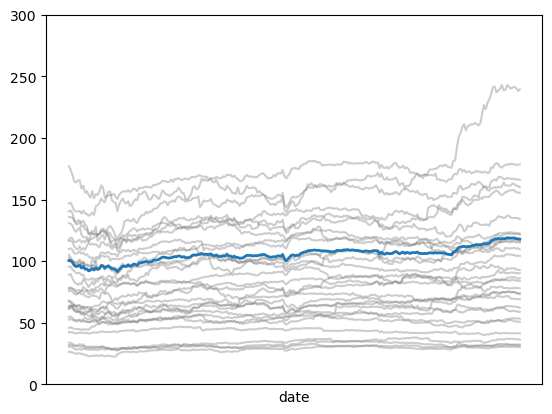

In [13]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
price.records.groupby("symbol", observed=True).plot(
    x="date",
    y="value",
    ax=ax,
    alpha=0.4,
    color="grey",
    legend=False,
    ylim=(0, 300),
    xticks=[],
)
index.records.plot(x="date", y="value", ax=ax, linewidth=2, legend=False)

<Axes: xlabel='symbol'>

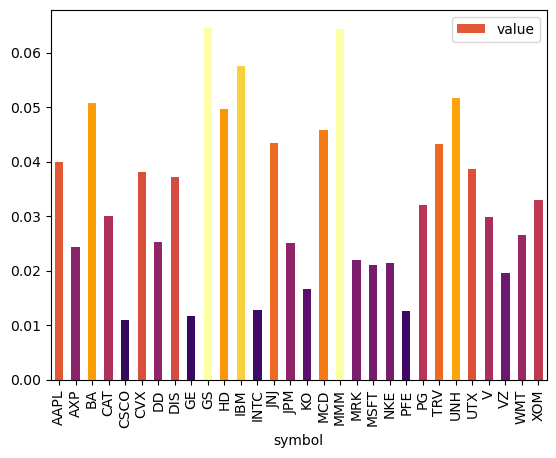

In [14]:
sMap = matplotlib.cm.ScalarMappable(
    norm=matplotlib.colors.Normalize(0, weight.records["value"].max()), cmap="inferno"
)
color = [sMap.to_rgba(x) for x in weight.records["value"]]
weight.records.plot.bar(x="symbol", y="value", color=color)

Define dynamic set `ds` and scalar `maxstock`.

In [15]:
trainingdays = 100
maxstock = 3
ds = m.addSet("ds", date, description="selected dates")
ds.setRecords(date.records["uni"][:100])

Declaration of the variables and equations used to formulate the optimization model

In [34]:
p = m.addVariable('p', 'binary', symbol, description = 'is stock included?')
w = m.addVariable('w', 'positive', symbol, description = 'what part of the portfolio')
slpos = m.addVariable('slpos', 'positive', date, description = 'positive slack')
slneg = m.addVariable('slneg', 'positive', date, description = 'negative slack')


## Defining the actual model
We know come to the decision problem, where we want to pick a small subset of the stocks together with some weights, such that this portfolio has a similar behavior to our overall Dow Jones index.

The model is based on a linear regression over the time series, but we minimize the loss using the L1-norm (absolute value), and allow only a fixed number of weights to take nonzero variable.

\begin{align}
\text{minimize} \qquad & \text{obj}:= \sum_{ds} \text{slpos}_{ds} + \text{slneg}_{ds} \\
\text{subject to}  \qquad & \sum_{s}  \text{price}_{ds, s} \cdot w_{s} =  \text{index}_{ds} +  \text{slpos}_{ds} -  \text{slneg}_{ds} & (\forall{ds}) \\
& w_{s} \leq p_{s} & (\forall{s}) \\
& \sum_{s}{p_{s}} \leq \text{maxstock} \\
& w_{s}\geq 0, \qquad p_{s}\in \{0,1\} & (\forall s) \\
&  \text{slpos}_{d}\geq 0, \qquad  \text{slneg}_{d}\geq 0 & (\forall d) 
\end{align}



In [35]:
fit = m.addEquation(name="deffit", domain=[ds], description='fit to Dow Jones indeex')
fit[ds] = Sum(s, price[ds,s] * w[s]) == index[ds] + slpos[ds] - slneg[ds]

pick = m.addEquation(name="defpick", domain=[s], description="can only use stok if picked")
pick[s] = w[s] <= p[s]

numstock = m.addEquation(name="defnumstock", description="few stocks allowed")
numstock.expr = Sum(s, p[s]) <= maxstock

Objective

In [36]:
obj = Sum(ds, slpos[ds] + slneg[ds])

Model

In [37]:
pickstock = Model(
        m,
        name="pickstock",
        equations=m.getEquations(),
        problem="MIP",
        sense=Sense.MIN,
        objective=obj,
    )

Specify 'maxstock' and 'trainingdays' and solve the model.

In [38]:
ds.setRecords(date.records['uni'][:100])
maxstock.setRecords(3)

Add options

In [39]:
m.addOptions({"optcr": 0.01, "reslim": 6})

Solve

In [40]:
pickstock.solve()

GamsExceptionExecution: GAMS return code not 0 (2), check C:\Users\jbroi\AppData\Local\Temp\tmpuuhiqrhl\_gams_py_gjo7.lst for more details

Generate reporting parameters

In [ ]:
fund = m.addParameter('fund', [date], description='Index fund report parameter')
fund[d] = Sum(s, price[d, s] * w.l[s]);
error = m.addParameter('error', [date], description='Absolute error')
error[d] = index[d] - fund[d]

Plotting of the results

<IPython.core.display.Javascript object>


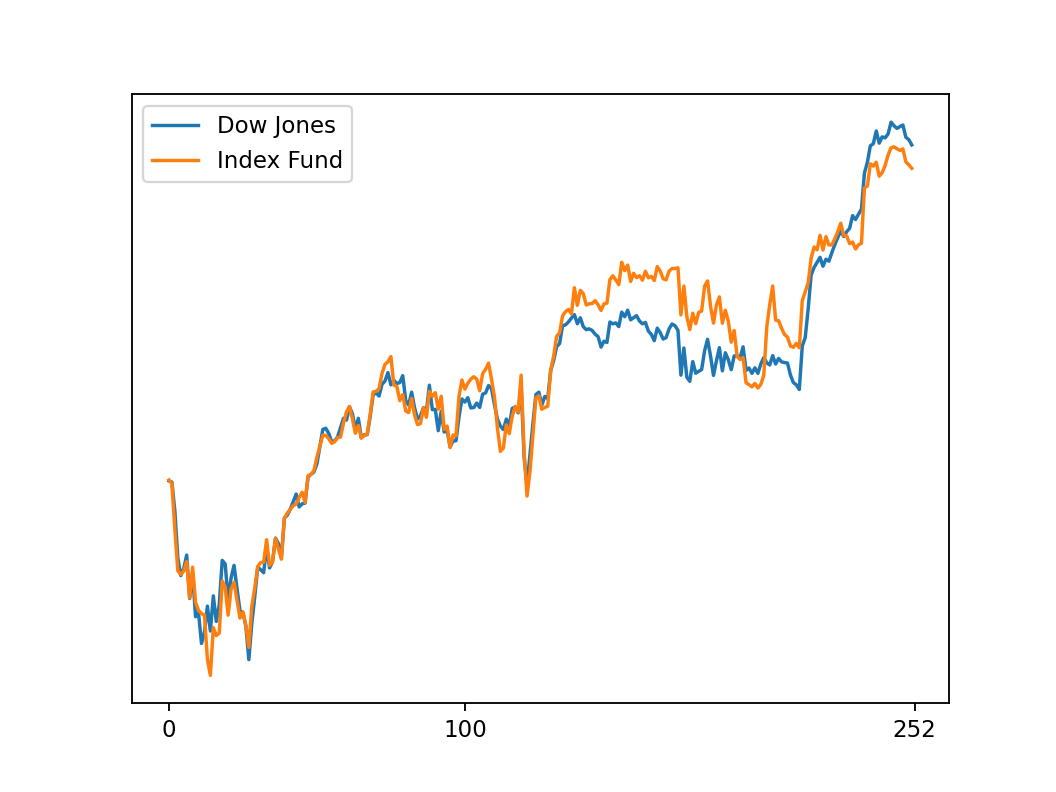

C:\Users\jbroi\AppData\Local\Temp\ipykernel_11308\4154540830.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  trainingDays = int(trainingdays.records.iloc[0])


<Axes: >

In [ ]:
fig, ax = plt.subplots()
trainingDays = int(trainingdays.records.iloc[0])
index.records.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date.records)], yticks=[], label="Dow Jones")
fund.records.plot(y="value", ax=ax, xticks=[0, trainingDays, len(date.records)], yticks=[], label="Index Fund")

<IPython.core.display.Javascript object>


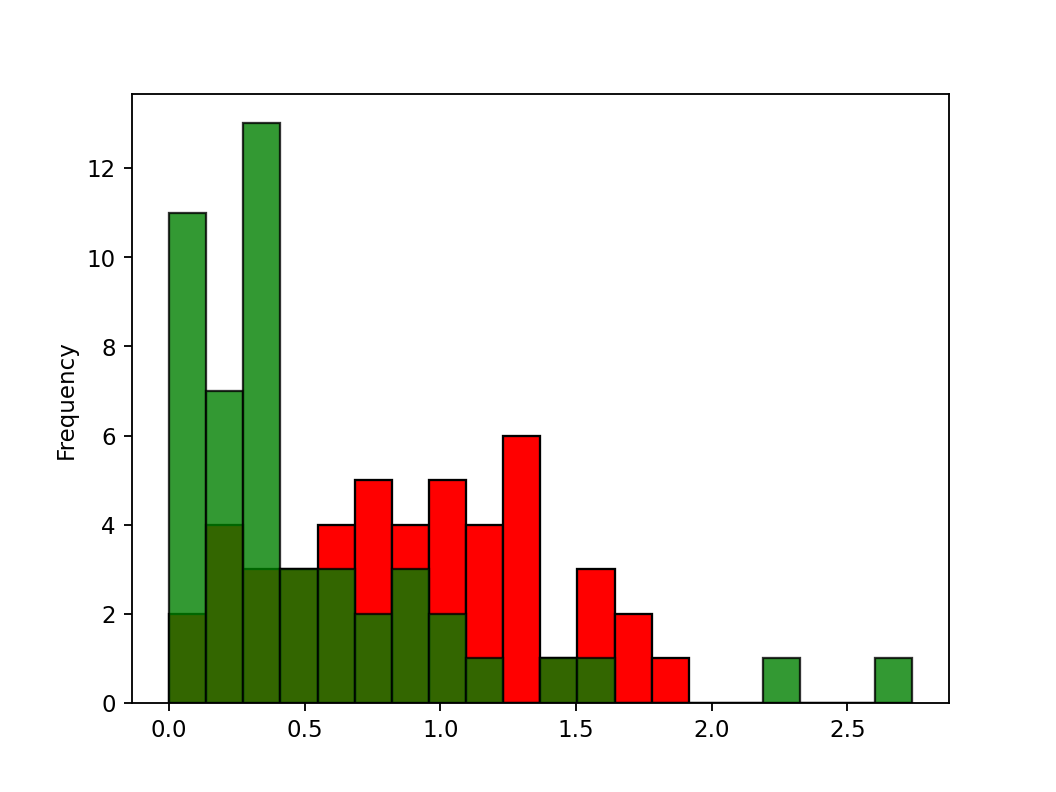

<Axes: ylabel='Frequency'>

In [ ]:
maxError = error.records['value'].max()
fig, ax = plt.subplots(edgecolor='black')
error.records['value'][trainingDays:].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='later', color='red', edgecolor='black')
error.records['value'][:trainingDays].plot.hist(x='date', y='value', ax=ax, bins=20, range=(0, maxError), label='training', color='green', alpha=0.8, edgecolor='black')